# Intro to Decision Trees
Authors: David Yerrington, Matt Brems

<img src="../images/sms1.png" align="left">

### Learning Objectives

- Understand the intuition behind decision trees.
- Calculate Gini.
- Describe how decision trees use Gini to make decisions.
- Fit, generate predictions from, and evaluate decision tree models.
- Interpret and tune `max_depth`, `min_samples_split`, `min_samples_leaf`.

## What should we do today?

In [1]:
import pandas as pd

df = pd.DataFrame({
    'Activity': ['Movies', 'Netflix', 'Beach', 'Netflix', 'Netflix', 'Beach'],
    'Day': ['Weekend', 'Weekday', 'Weekend', 'Weekday', 'Weekday', 'Weekend'],
    'Weather': ['Rainy', 'Sunny', 'Sunny', 'Rainy', 'Rainy', 'Sunny']
})

df

,Activity,Day,Weather
0,Movies,Weekend,Rainy
1,Netflix,Weekday,Sunny
2,Beach,Weekend,Sunny
3,Netflix,Weekday,Rainy
4,Netflix,Weekday,Rainy
5,Beach,Weekend,Sunny


<details><summary>It's a weekday. Based on our past behavior, what do you think we'll do today?</summary>

- Watch Netflix.
- In 100% of past cases where it's a weekday we've watched Netflix!

|$Y = $ Activity|$X_1 = $ Day|$X_2 = $ Weather|
|:---------:|:--------------:|:----------:|
|   Netflix  |      Weekday     |   Sunny  |
|   Netflix  |      Weekday     |   Rainy  |
|   Netflix  |      Weekday     |   Rainy  |

</details>

<details><summary>It's a weekend. Based on our past behavior, what do you think we'll do?</summary>

- Either go to the movies or got to the beach... but we can't say with certainty whether we'd go to the beach or go to the movies.
- Based on our past behavior, we go to the movies on 1/3 of weekend days and we go to the beach on 2/3 of weekend days. (You can think of `.predictproba()`)
- If I **had** to make a guess here, I'd probably predict that we would go to the beach, but we may want to use additional information to be certain.

|$Y = $ Activity|$X_1 = $ Day|$X_2 = $ Weather|
|:---------:|:--------------:|:----------:|
|  Movies |      Weekend     |   Rainy  |
|  Beach  |      Weekend     |   Sunny  |
|  Beach  |      Weekend     |   Sunny  |

</details>

<details><summary>It's the weekend and the weather is sunny! Based on our past behavior, what do you think we'll do?</summary>

- Go to the beach.
- In 100% of past cases where the weather is sunny and where it's a weekend, we've gone to the beach.

|$Y = $ Activity|$X_1 = $ Day|$X_2 = $ Weather|
|:---------:|:--------------:|:----------:|
|  Beach  |      Weekend     |   Sunny  |
|  Beach  |      Weekend     |   Sunny  |

</details>

# Decision Trees: Overview

A decision tree:
- takes a dataset consisting of $X$ and $Y$ data, 
- finds rules based on our $X$ data that partitions (splits) our data into smaller datasets such that
- by the bottom of the tree, the values $Y$ in each "leaf node" are as "pure" as possible.

We frequently see decision trees represented by a graph.

<!-- <img src="../images/order_food_dt.png" alt="order_food" width="750"/> -->
<img src="../images/decision_tree_1.png" alt="order_food" width="750"/>


- (This image was created using [Draw.io](https://www.draw.io/).)

### Terminology
Decision trees look like upside down trees. 
- What we see on top is known as the "root node," through which all of our observations are passed.
- At each internal split, our dataset is partitioned.
- A "parent" node is split into two or more "child" nodes.
- At each of the "leaf nodes" (colored blue), we contain a subset of records that are as pure as possible.
    - In the example above, each leaf node is perfectly pure. Once we get to a leaf node, every observation in that leaf node has the exact same value of $Y$!
    - There are ways to quantify the idea of "purity" here so that we can let our computer do most of the tree-building (model-fitting) process... we'll come back to this later.

Decision trees are also called "**Classification and Regression Trees**," sometimes abbreviated "**CART**."
- [DecisionTreeClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [DecisionTreeRegressor Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

## 20 Questions

If you aren't familiar with the game [20 Questions](https://en.wikipedia.org/wiki/Twenty_Questions), it's a game with two players (or teams). 
- Player 1 thinks of an item but doesn't say what the item is.
- Player 2 then attempts to guess what the item is by asking a series of 20 questions with a yes or no answer.
- If player 2 correctly guesses the item, then player 2 wins!
- If player 2 does not correctly guess the item, then player 1 wins!

<!-- Let's play a quick game of "5 Questions" to get a feel for it. -->

---



#### Decision trees operate in a fashion that's pretty similar to 20 Questions.
- Decisions are made in a sequential fashion. Once you know a piece of information, you use that piece of information when asking future questions.
    - Example: If you know that the item you're trying to guess is a person, then you can use that information to ask better subsequent questions.
- It's possible to get lucky by making very specific guesses early, but it's pretty unlikely that this is a winning strategy.
    - Example: If you asked, "Is it an airplane? Is it a boat? Is it a car?" as your first three questions, it's not very likely that you'll win the game.

When fitting a decision tree, we're effectively getting our computer to play a game of 20 Questions. We give the computer some data and it figures out the best $X$ variable to split on at the right time.
- Above, our "what food should we order?" decision tree first asked what the weather was, **then** asked whether it was a weekday or weekend.
- If we had asked "is it a weekday or weekend" first, we'd have ended up with a slightly more complicated decision tree.

Just like with all of our models, in order for the computer to learn which $X$ variable to split on and when, the computer needs a loss function to quantify how good a particular split is. This is where the idea of **purity** comes into play.

## Purity in Decision Trees

When quantifying how "pure" a node is, we want to see what the distribution of $Y$ is in each node, then summarize this distribution with a number.

<img src="../images/decision_tree_1.png" alt="order_food" width="750"/>

- For continuous $Y$ (i.e. using a decision tree to predict income), the default option is mean squared error.
    - This is the `criterion = 'mse'` argument in `DecisionTreeRegressor`.
    - When the decision tree is figuring out which split to make at a given node, it picks the split that maximizes the drop in MSE from the parent node to the child node.
    

- For discrete $Y$, the default option is the Gini impurity. *(Bonus: This is not quite the same thing as the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient).)*

$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
\text{Gini impurity (2 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 \\
\text{Gini impurity (3 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 - P(\text{class 3})^2 \\
\end{eqnarray*}
$$

In [2]:
# Create our y variable from our "what should we do" dataframe.
y = df['Activity'].to_list()
y

['Movies', 'Netflix', 'Beach', 'Netflix', 'Netflix', 'Beach']

In [3]:
# Define Gini function, called gini.
def gini(obs):
    
    # Create a list to store my squared class probabilities.
    gini_sum = []
    
    # Iterate through each class.
    for class_i in set(obs):
        
        # Calculate observed probability of class i.
        prob = (obs.count(class_i) / len(obs))
        
        # Square the probability and append it to gini_sum.
        gini_sum.append(prob ** 2)
        
    # Return Gini impurity.
    return 1 - sum(gini_sum)

In [4]:
1 - (1/6)**2 - (3/6)**2 - (2/6)**2

0.6111111111111112

In [5]:
# Check to see if your Gini function is correct on the 
# "where should we eat" data. (Should get 0.6111.)
gini(y)

0.6111111111111112

### Gini Practice

<details><summary>What is the Gini impurity of a node when every item is from the same class?</summary>
    
- Our Gini impurity is zero.

$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
&=& 1 - P(\text{class 1})^2 \\
&=& 1 - 1^2 \\
&=& 1 - 1 \\
&=& 0
\end{eqnarray*}
$$
</details>

In [6]:
# What is Gini when every item is from the same class?
gini(['Netflix', 'Netflix', 'Netflix'])

0.0

<details><summary>What is the Gini impurity of a node when we have two classes, each with two items?</summary>
    
- Our Gini impurity is 0.5.

$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
&=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 \\
&=& 1 - \left(\frac{1}{2}\right)^2 - \left(\frac{1}{2}\right)^2 \\
&=& 1 - \frac{1}{4} - \frac{1}{4} \\
&=& \frac{1}{2}
\end{eqnarray*}
$$
</details>

In [7]:
# What is Gini when we have two classes, each with two items?
gini(['Netflix', 'Netflix', 'Beach', 'Beach'])

0.5

<details><summary>What is the Gini impurity of a node when we have two classes, each with three items?</summary>
    
- Our Gini impurity is 0.5.

$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
&=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 \\
&=& 1 - \left(\frac{1}{2}\right)^2 - \left(\frac{1}{2}\right)^2 \\
&=& 1 - \frac{1}{4} - \frac{1}{4} \\
&=& \frac{1}{2}
\end{eqnarray*}
$$
</details>

In [8]:
# What is Gini when we have two classes, each with three items?
gini(['Netflix', 'Netflix', 'Beach', 'Beach', 'Netflix', 'Beach'])

0.5

<details><summary>What is the Gini impurity of a node when we have three classes, each with two items?</summary>
    
- Our Gini impurity is 0.6667.

$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
&=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 - P(\text{class 3})^2 \\
&=& 1 - \left(\frac{1}{3}\right)^2 - \left(\frac{1}{3}\right)^2 - \left(\frac{1}{3}\right)^2 \\
&=& 1 - \frac{1}{9} - \frac{1}{9} - \frac{1}{9} \\
&=& 1 - \frac{1}{3} \\
&=& \frac{2}{3}
\end{eqnarray*}
$$

In [9]:
# What is Gini when we have three classes, each with two items?
gini(['Netflix', 'Netflix', 'Beach', 'Beach', 'Movies', 'Movies'])

0.6666666666666667

<details><summary>Summary of Gini Impurity Scores</summary>

- In the binary case, Gini impurity ranges from 0 to 0.5.
- If we have three classes, Gini impurity ranges from 0 to 0.66667.
- If we have $k$ classes, Gini impurity ranges from 0 to $1-\frac{1}{k}$.
- In all cases, a Gini impurity of 0 means maximum purity - all of our observations are from the same class!
</details>

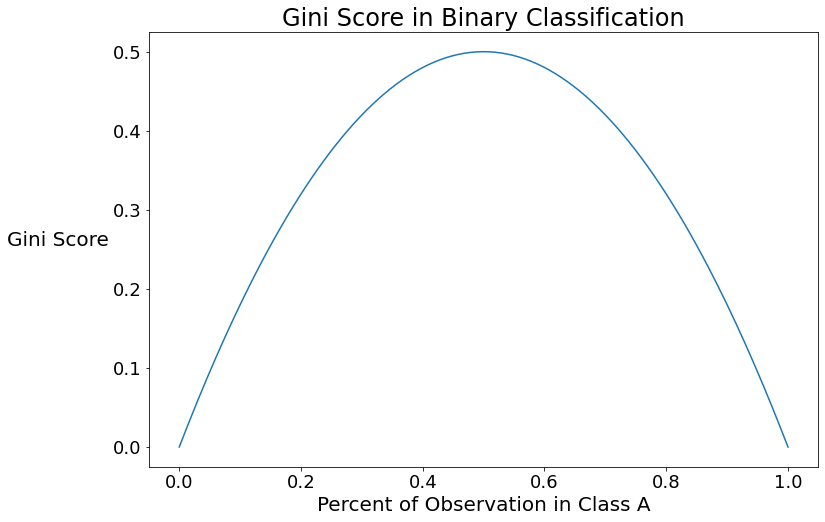

In [10]:
# Import libraries.
import numpy as np
import matplotlib.pyplot as plt

# Set figure size.
plt.figure(figsize = (12,8))

# Generate x values (for percentage of obs. in class A).
percent_in_class_A = np.linspace(0, 1, 200)
percent_in_class_B = 1 - percent_in_class_A

# Calculate Gini values.
gini_values = 1 - np.square(percent_in_class_A) - np.square(percent_in_class_B)

# Plot line.
plt.plot(percent_in_class_A,
         gini_values)

# Establish title, axes, and labels.
plt.title('Gini Score in Binary Classification', fontsize = 24)
plt.xlabel('Percent of Observation in Class A', fontsize = 20)
plt.ylabel('Gini Score', fontsize = 20, rotation = 0, ha = 'right')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18);

### So how does a decision tree use Gini to decide which variable to split on?

- At any node, consider the subset of our dataframe that exists at that node.
- Iterate through each variable that could potentially split the data.
- Calculate the Gini impurity for every possible split.
- Select the variable that causes the greatest decrease in Gini impurity from the parent node to the child node.

In [11]:
df

,Activity,Day,Weather
0,Movies,Weekend,Rainy
1,Netflix,Weekday,Sunny
2,Beach,Weekend,Sunny
3,Netflix,Weekday,Rainy
4,Netflix,Weekday,Rainy
5,Beach,Weekend,Sunny


<details><summary>What is the decrease in Gini impurity if we split on $X_1$? (Weekend vs. Weekday)</summary>

- Answer: 0.389

<img src="../images/gini_decrease_1.png" alt="gini_decrease" width="500"/>

In [12]:
# gini_weekend = 1 - (1/3)**2 - (2/3)**2
# gini_weekday = 1 - (3/3)**2
gini_weekend = gini(['Beach', 'Beach', 'Movie'])
gini_weekday = gini(['Netflix', 'Netflix', 'Netflix'])
gini_child = (gini_weekday + gini_weekend)/2
decrease = gini(y) - gini_child
decrease

0.38888888888888895

<details><summary>What is the decrease in Gini impurity if we split on $X_2$? (Sunny Day vs. Rainy Day)</summary>
    
- Answer: 0.167

<img src="../images/gini_decrease_2.png" alt="gini_decrease" width="500"/>

In [13]:
# gini_sunny = 1 - (1/3)**2 - (2/3)**2 
# gini_rainy = 1 - (1/3)**2 - (2/3)**2
gini_sunny = gini(['Netflix', 'Beach', 'Beach'])
gini_rainy = gini(['Movies', 'Netflix', 'Netflix'])
gini_child = (gini_rainy + gini_sunny)/2
decrease = gini(y) - gini_child
decrease

0.16666666666666674

One consequence of this is that a decision tree is fit using a **greedy** algorithm. Simply put, a decision tree makes the best short-term decision by optimizing at each node individually. _This might mean that our tree isn't optimal in the long run!_

## Building a Decision Tree

In [14]:
# Read in Titanic data.
titanic = pd.read_csv('../titanic_clean.csv')

# Change sex to int.
titanic['Sex'] = titanic['Sex'].map({'male':0, 'female':1})

# Create embarked dummies.
titanic = pd.get_dummies(titanic, columns=['Embarked'], drop_first=True)

# Create X and y
X = titanic.drop(columns=['Survived','PassengerId','Name'])
y = titanic['Survived']

# Conduct train/test split.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
# Check out first five rows of X_train.
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
43,2,1,5.0,1,2,27.7500,0,1
42,3,0,28.5,0,0,7.2292,0,0
73,1,0,71.0,0,0,34.6542,0,0
167,3,0,24.0,0,0,7.0500,0,1
449,3,0,32.0,0,0,7.8542,0,1


In [16]:
# Import model.
from sklearn.tree import DecisionTreeClassifier

In [17]:
# Instantiate model.
dt = DecisionTreeClassifier(random_state = 42)

In [18]:
# Fit model.
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [19]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.9939759036144579
Score on testing set: 0.7149532710280374


<details><summary>What conclusion would you make here?</summary>

- Our model is **very** overfit to the data.
</details>

When fitting a decision tree, your model will always grow until it nearly perfectly predicts every observation!
- This is like playing a game of 20 questions, but instead calling it "Infinite Questions." You're always going to be able to win!

<details><summary>Intuitively, what might you try to do to solve this problem?</summary>
    
- As with all models, try to gather more data.
- As with all models, remove some features.
- Is there a way for us to stop our model from growing? (Yes!)
</details>

### Hyperparameters of Decision Trees
There are three hyperparameters of decision trees that we may commonly tune in order to prevent overfitting.

- `max_depth`: The maximum depth of the tree.
    - By default, the nodes are expanded until all leaves are pure (or some other argument limits the growth of the tree).
    - In the 20 questions analogy, this is like "How many questions we can ask?"
- `min_samples_split`: The minimum number of samples required to split an internal node.
    - By default, the minimum number of samples required to split is 2. That is, if there are two observations in a node and if we haven't already achieved maximum purity, we can split it!
- `min_samples_leaf`: The minimum number of samples required to be in a leaf node (a terminal node at the end of the tree).
    - By default, the minimum nubmer of samples required in a leaf node is 1. (This should ring alarm bells - it's very possible that we'll overfit our model to the data!)

[Source: Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [20]:
# Instantiate model with:
# - a maximum depth of 5.
# - at least 7 samples required in order to split an internal node.
# - at least 3 samples in each leaf node.
# - random state of 42.

dt = DecisionTreeClassifier(max_depth = 5,
                            min_samples_split = 7,
                            min_samples_leaf = 3,
                            random_state = 42)

In [21]:
# Fit model.
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=7,
                       random_state=42)

In [22]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.8714859437751004
Score on testing set: 0.7897196261682243


#### Let's GridSearch to try to find the best tree.

- Check [3, 5, 7, 10] for `max_depth`.
- Check [5, 10, 15, 20] for `min_samples_split`.
- Check [2, 3, 4, 5, 6, 7] for `min_samples_leaf`.
- Run 5-fold cross-validation.

<details><summary>How many models are being fit here?</summary>

- 4 * 4 * 6 * 5 = 480 models.
</details>

In [23]:
from sklearn.model_selection import GridSearchCV

In [47]:
dt = DecisionTreeClassifier()

params = {
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : [5, 10, 15, 20],
    'min_samples_leaf' : range(2,8),
#     'ccp_alpha' : [0, 0.001, 0.01]
}

grid = GridSearchCV(dt,
                   param_grid=params,
                   cv = 5,
                   verbose=2,
                   n_jobs = -1)

In [48]:
%%time
# jupyter magic

# Let's GridSearch over the above parameters on our training data.
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 617 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': range(2, 8),
                         'min_samples_split': [5, 10, 15, 20]},
             verbose=2)

In [49]:
# What is our best decision tree?
grid.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=6, min_samples_split=15)

In [50]:
# What were the best parameters of our decision tree?
grid.best_params_

{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 15}

In [51]:
# What was the cross-validated score of the above decision tree?
grid.best_score_

0.8172525252525252

In [52]:
# Evaluate model.
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')

Score on training set: 0.8775100401606426
Score on testing set: 0.7523364485981309


In [53]:
# Generate predictions on test set.
preds = grid.predict(X_test)

In [54]:
# Import confusion_matrix.
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

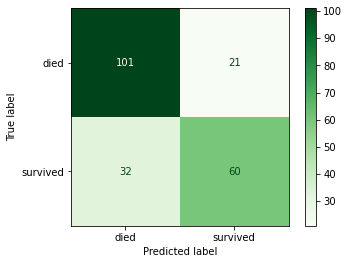

In [55]:
# Generate confusion matrix.
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(grid, X_test, y_test, display_labels=['died', 'survived'], cmap='Greens');

In [56]:
# Calculate sensitivity/recall/true pos rate.

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens, 4)}')

Sensitivity: 0.6522


In [57]:
# Calculate specificity/true neg rate.

spec = tn / (tn + fp)

print(f'Specificity: {round(spec, 4)}')

Specificity: 0.8279


## Feature Importances

- Decision trees can give us the relative importance of features: the higher the number, the more important the predictor was to deciding splits at nodes.
- From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_): "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance."

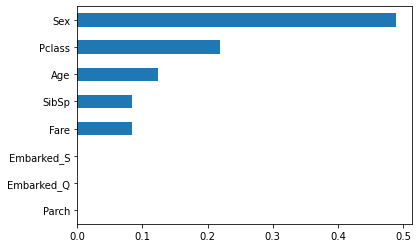

In [64]:
pd.Series(grid.best_estimator_.feature_importances_, X_train.columns).sort_values().plot(kind='barh');

## Visualizing the Output of Decision Trees

One advantage to using a decision tree is that you can easily visualize them in `sklearn`. The two functions used to do this are `plot_tree` and `export_text`.
- [`plot_tree` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree)
- [`export_text` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html)

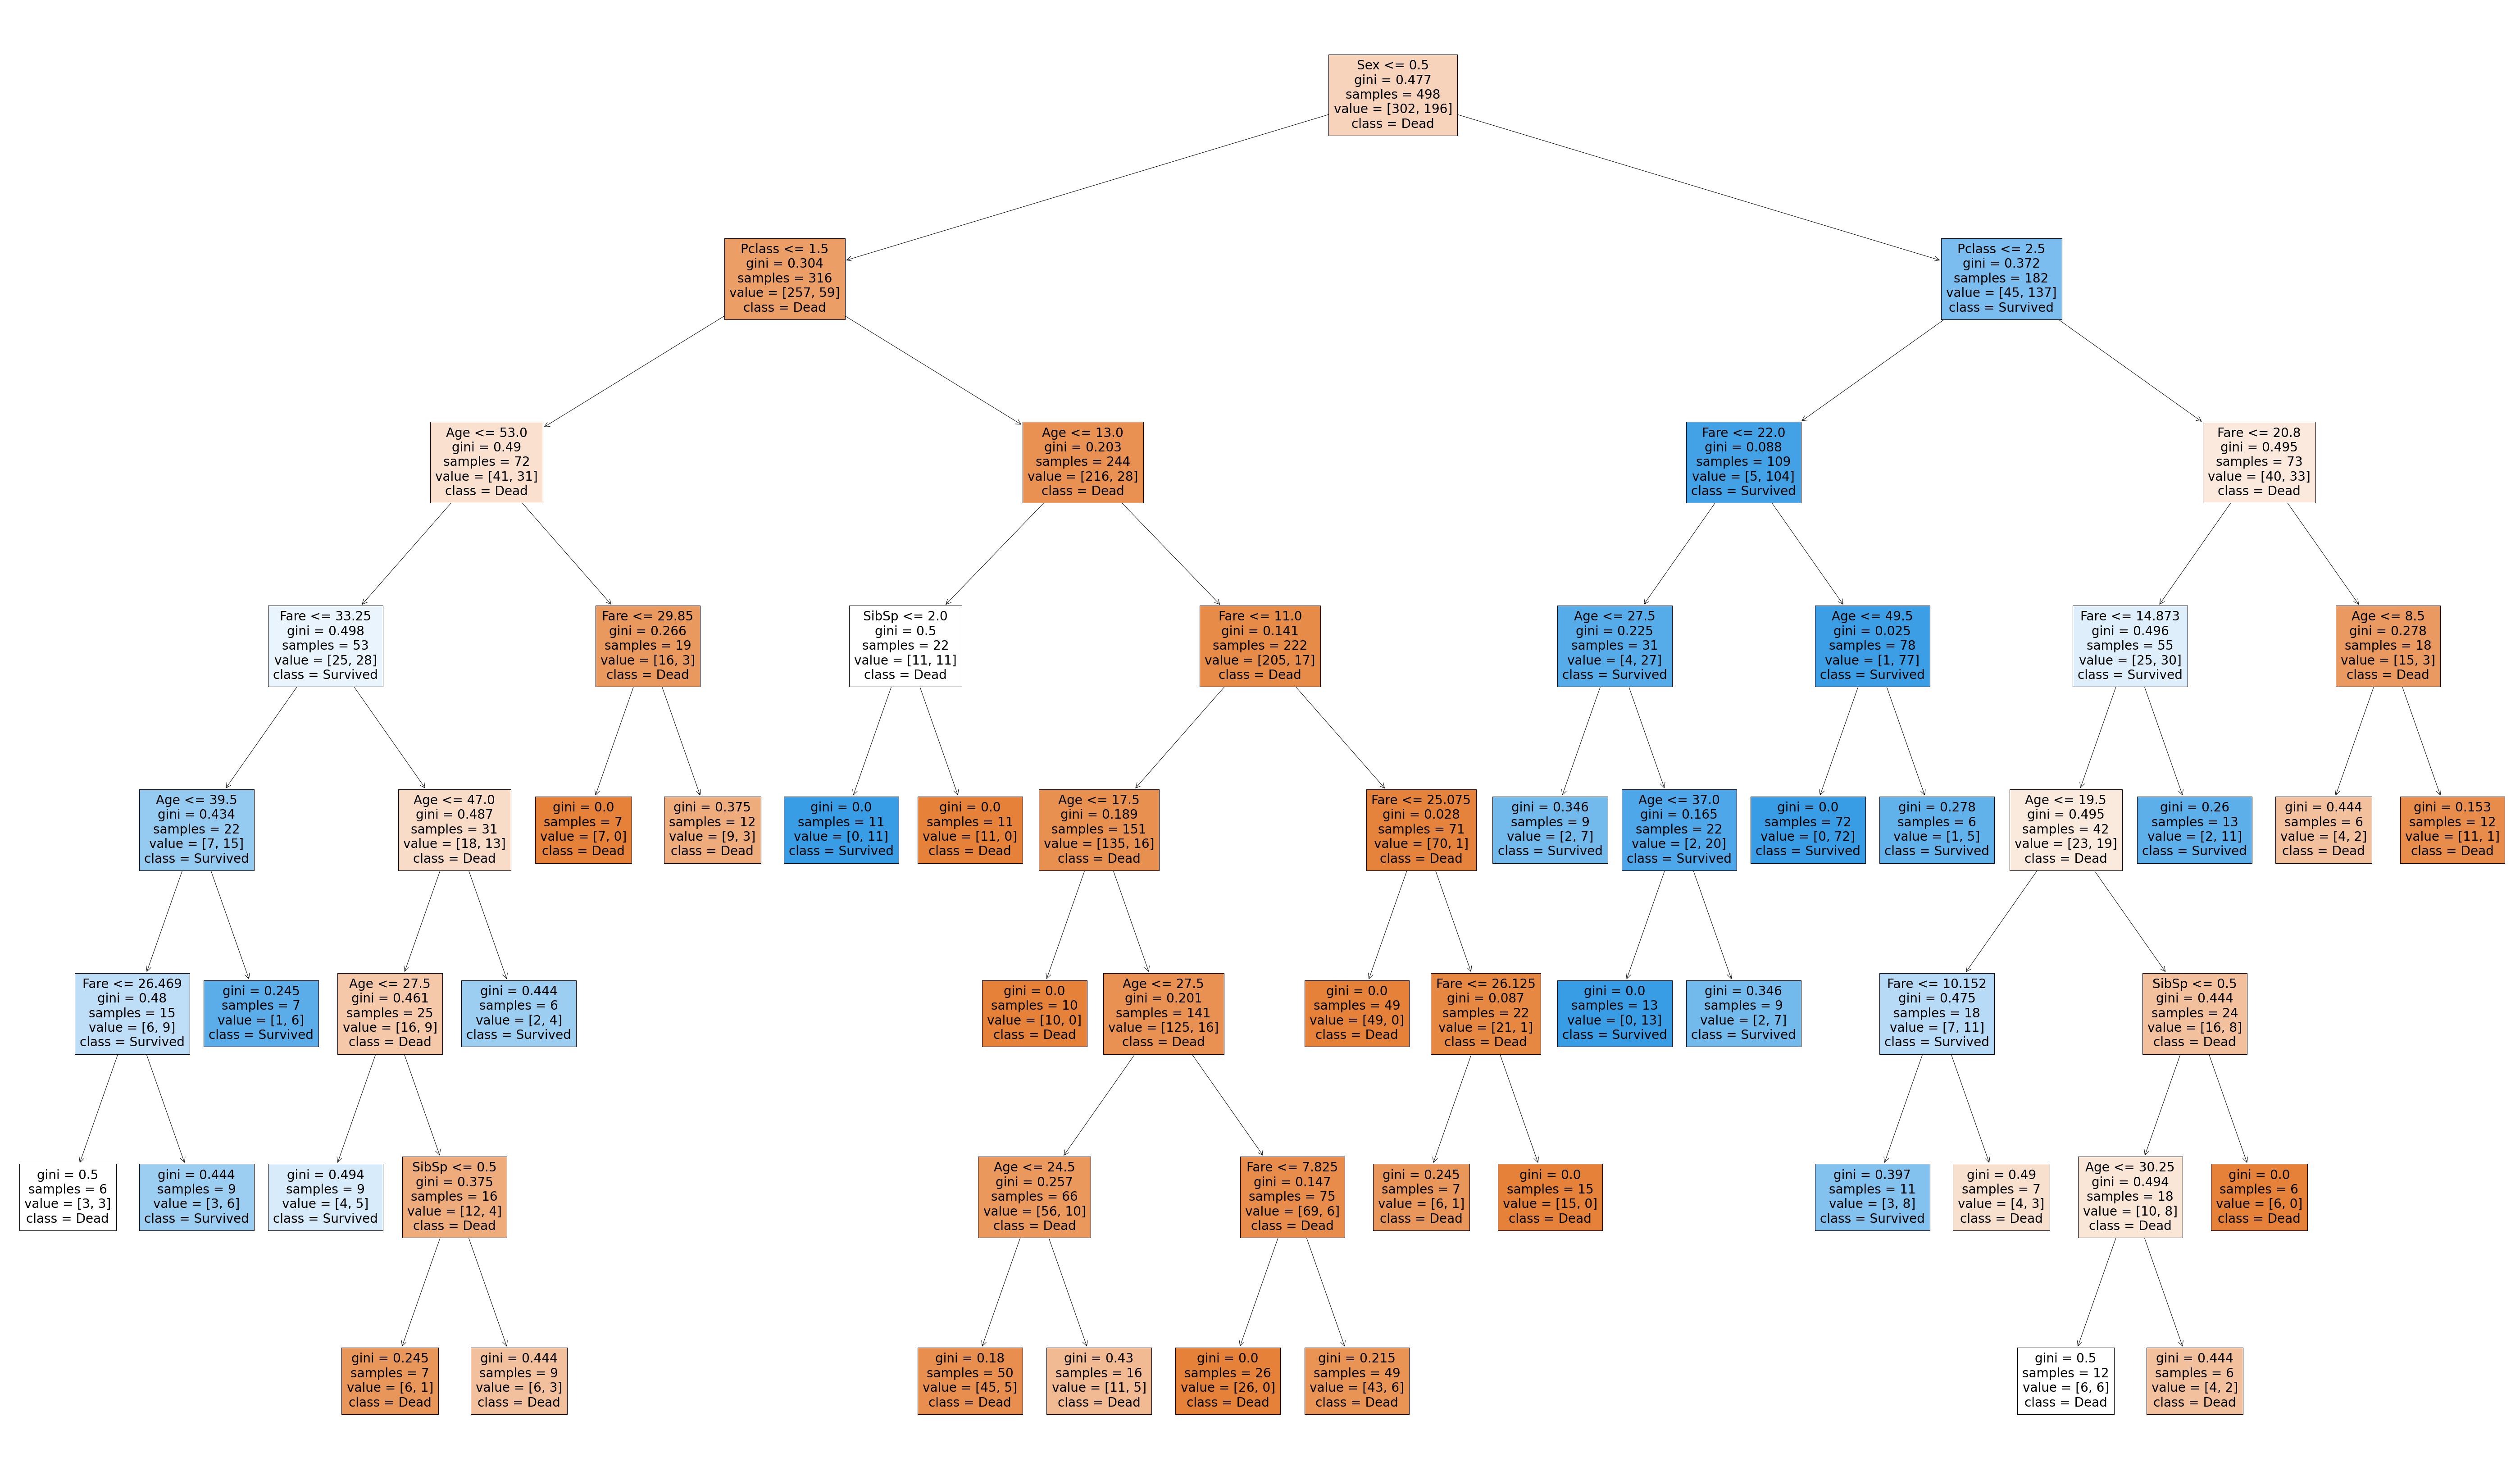

In [50]:
# Import plot_tree from sklearn.tree module.
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Establish size of figure.
plt.figure(figsize = (100, 60))

# Plot our tree.
plot_tree(grid.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Dead', 'Survived'],
          filled = True);

In [52]:
# Import export_text from sklearn.tree module.
from sklearn.tree import export_text

# Print out tree in plaintext.
print(export_text(grid.best_estimator_, feature_names=list(X_train.columns)))

|--- Sex <= 0.50
|   |--- Pclass <= 1.50
|   |   |--- Age <= 53.00
|   |   |   |--- Fare <= 33.25
|   |   |   |   |--- Age <= 39.50
|   |   |   |   |   |--- Fare <= 26.47
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Fare >  26.47
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  39.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- Fare >  33.25
|   |   |   |   |--- Age <= 47.00
|   |   |   |   |   |--- Age <= 27.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Age >  27.50
|   |   |   |   |   |   |--- SibSp <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- SibSp >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  47.00
|   |   |   |   |   |--- class: 1
|   |   |--- Age >  53.00
|   |   |   |--- Fare <= 29.85
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  29.85
|   |   |   |   |--- class: 0
|   |--- Pclass >  1.50
|   |   |--- Age <= 13.00
|   |   |   |--- SibSp <= 2.00


As with all visualizations, just because we _can_ doesn't mean that we _should_. If our depth is much larger than 2 or 3, the tree may be unreadable.

While these visuals may be helpful to us, it may be helpful to clean it up before presenting it to stakeholders.

## What's so great about decision trees?


### 1. We don't have to scale our data.
Much in the same way that decision trees don't need much preprocessing in order to work, the base assumptions around how data is used and estimated don't rely on scale to be effective.

### 2. Decision trees don't care about how your data is distributed.

Is your data heavily skewed or not normally distributed? Decision trees are nonparametric, meaning we don't make assumptions about how our data or errors are distributed.

### 3. Easy to interpret.

The output of a decision tree is easy to interpet and thus relatable to non-technical people.

### 4. Speed.

Decision trees are fit very quickly!

> **Protip**
>
> Consider creating a benchmark using a decision tree to understand how one might behave on its own before using a more complicated method.  Do your best to understand how a simple model behaves on a set of data before using a more complex model. This is a great practice to get into.

## What are the downsides of decision trees?


### 1. Decision trees can very easily overfit.
Decision trees often suffer from high error due to variance, so we need to take special care to avoid this. (Luckily, there are lots of algorithms designed to do exactly this!)

### 2. Decision trees are locally optimal.
Because we're making the best decision at each node (greedy), we might end up with a worse solution in the long run.

### 3. Decision trees don't work well with unbalanced data.
We often will bias our results toward the majority class. We need to take steps to avoid this as well! (Check out the `class_weight` parameter if you're interested.)

## Interview Question

<details><summary>If you're comparing decision trees and logistic regression, what are the pros and cons of each?</summary>
    
(Answers may vary; this is not an exhaustive list!)
- **Interpretability**: The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.) However, this is complicated and not easy for non-technical audiences. Decision trees are interpretable; it is easy to explain to show a picture of a decision tree to a client or boss and get them to understand how predictions are made.
- **Performance**: Decision trees have a tendency to easily overfit, while logistic regression models usually do not overfit as easily.
- **Assumptions**: Decision trees have no assumptions about how data are distributed; logistic regression does make assumptions about how data are distributed.
- **Frequency**: Logistic regression is more commonly used than decision trees.
- **Y variable**: Decision trees can handle regression and classification problems; logistic regression is only really used for classification problems.
</details>